## My attempt to use the pipeline of AutoMIND from the https://github.com/mackelab/automind/ on our data from brain organoids
The aproximated posterior '../automind/datasets/discovered_posterior_samples/synthetic/' (DGM|PSD) meaning it's the posterior conditioned on 
- PSD spectrum from 0.5 Hz to 495.5 Hz with resolution 0.5 Hz

Prerequisites: 
 - Dowloaded AutoMIND from https://github.com/mackelab/automind/
 - Dataset of spikes times saved in a dictionary 

Here in this notebook, I want to show example code of what I did, where I have experienced issues and what I find is not making sense for me.

### Workflow 
We are going to look for the best match within the posterior samples of df_xos for four stats together at once : burst_num,IBI mean, IBI CV, burst width. I know it does not make sense to condition on burst num but I am keeping the data analysis time window the same as in posterior samples (200 seconds). This is an atefact of an old thinking I had.  
These samples are loaded from the AutoMIND repository. 
Then I am also adjusting the burst detection function. But it does not really make sense to change it for the input data and for the reruned posterior samples once and not when creating the database. 

### Results
- as this posterior is very expresive the results are much better than the '../automind/datasets/discovered_posterior_samples/organoids/'
- have to oversample a lot

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

#mpl_rc = "automind/assets/matplotlibrc"
#plt.style.use(mpl_rc)

import numpy as np
import pandas as pd
from time import time
import pickle

import brian2 as b2
from automind.sim import b2_interface, runners
from automind.inference import inferer
from automind.utils import data_utils, analysis_utils, dist_utils, plot_utils
from automind.analysis import spikes_summary

Loading the data from old the company (?)

In [60]:
# this pickle file constains information about the recording setup
#file_path = '/archive3/group/vogelgrp/spiketimes/210421_M02753_Network_000272_well005.pkl'
file_path = '/archive3/group/vogelgrp/spiketimes/210421_M02734_Network_000274_well000.pkl'
file_path = '/archive3/group/vogelgrp/spiketimes/201022_M02392_Network_000021_well001.pkl'
# Open the file in read-binary mode and load its contents
with open(file_path, 'rb') as file:
    data_info = pickle.load(file)

# Now, 'data' contains the deserialized object from the .pkl file
print(data_info)

# Load the .npz file
#data_npz_in_ms = np.load('/archive3/group/vogelgrp/spiketimes/210421_M02753_Network_000272_well005.npz')
#data_npz_in_ms = np.load('/archive3/group/vogelgrp/spiketimes/210421_M02734_Network_000274_well000.npz')
data_npz_in_ms = np.load('/archive3/group/vogelgrp/spiketimes/201022_M02392_Network_000021_well001.npz')
data = {int(key): data_npz_in_ms[key]/ 1000 for key in data_npz_in_ms}


{'date': '201022', 'plate': 'M02392', 'type': 'Network', 'scanid': '000021', 'well': 'well001', 'dataset': 'TESS_008_009_010_II', 'key': '201022_M02392_Network_000021_well001', 'detail': '009 st3G+st2N', 'subject': 9.0, 'group': 'patient', '3 week': '22.10.2020', '6 week': '11.11.2020', 'comments': nan, 'family': 'Tess1'}


---
# Load trained DGM, meta info, and dataset
First, we load the trained deep generative model (Normalizing Flow) stored in the `posterior.pickle` file, along with some analysis parameters we need in `params_dict_analysis_updated.pickle`.

As its name suggests, the posterior file contains the trained posterior estimator neural network, constructed using the `sbi` package. The one we use below is particular to the type of data feature we wish to target, i.e., high-dimensional PSDs. 

In addition, it contains some meta information, like the specific data features it was trained on (`freq_bounds`)---and hence must be passed during inference---as well as data preprocessing steps, which must also be applied to the target observation as well.

In [46]:
#this whole cells is just to load params_dict (maybe we can do this in a more elegant way)
data_dirs = "../automind/datasets/discovered_posterior_samples/synthetic/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
df_xos, posterior, params_dict = data_utils.load_df_posteriors(path_dict) #df_xos are the posterior samples
_, _, _, _, cols_psd = data_utils.separate_feature_columns(df_xos)
print(posterior)

posterior.pickle ['7149324_posterior.pickle']
params_dict_analysis_updated.pickle ['7149324_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['7149324_MK1_summary_data_merged.csv']
1003 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [4]:
df_xos

params_settings.batch_seed  params_settings.random_seed       x_o  \
0                         5065886                          121  160810_7   
1                         5065886                          252  160810_7   
2                         5065886                          506  160810_7   
3                         5065886                          686  160810_7   
4                         5065886                          687  160810_7   
...                           ...                          ...       ...   
22513                     5065886                      2251268  170316_7   
22514                     5065886                      2251545  170316_7   
22515                     5065886                      2251570  170316_7   
22516                     5065886                      2251607  170316_7   
22517                     5065886                      2251783  170316_7   

              inference.type  infer.log_prob  params_net.exc_prop  \
0                    NPE_map       19.683207             0.711148   
1                   NPE_mean       -2.746665             0.866685   
2      NPE_samples_prune_100       14.984883             0.974112   
3      NPE_samples_prune_100       14.604634             0.971159   
4      NPE_samples_prune_100       14.562688             0.962199   
...                      ...             ...                  ...   
22513  NPE_samples_prune_100       11.760282             0.774792   
22514  NPE_samples_prune_100       11.759824             0.964865   
22515  NPE_samples_prune_100       11.759709             0.937088   
22516  NPE_samples_prune_100       11.759625             0.777582   
22517  NPE_samples_prune_100       11.759564             0.731861   

       params_net.p_e2e  params_net.p_e2i  params_net.p_i2e  params_net.p_i2i  \
0              0.010282          0.098992          0.075468          0.087736   
1              0.043116          0.049603          0.095330          0.121664   
2              0.016238          0.074929          0.067681          0.093378   
3              0.097582          0.015631          0.140294          0.072632   
4              0.048911          0.011998          0.134332          0.095335   
...                 ...               ...               ...               ...   
22513          0.041687          0.083483          0.057655          0.150420   
22514          0.021371          0.013124          0.074981          0.052744   
22515          0.017266          0.098095          0.076028          0.113907   
22516          0.060020          0.085251          0.064471          0.090191   
22517          0.012209          0.059534          0.124214          0.187406   

       ...  psd_495.5  psd_496.0  psd_496.5  psd_497.0  psd_497.5  psd_498.0  \
0      ...   0.000009   0.000011   0.000012   0.000013   0.000011   0.000008   
1      ...   0.025841   0.029574   0.034983   0.038651   0.042350   0.033931   
2      ...   0.003235   0.002405   0.005246   0.010513   0.010994   0.008480   
3      ...   0.016035   0.019534   0.018042   0.023328   0.025329   0.014097   
4      ...   0.003104   0.003939   0.005523   0.004745   0.008071   0.014578   
...    ...        ...        ...        ...        ...        ...        ...   
22513  ...   0.067583   0.072190   0.081233   0.098761   0.105573   0.127711   
22514  ...   0.305354   0.439354   0.576952   0.714330   0.972156   1.449932   
22515  ...   0.003529   0.003482   0.003685   0.003790   0.003840   0.003461   
22516  ...   0.317784   0.348226   0.343825   0.340634   0.429065   0.443049   
22517  ...   0.014935   0.015512   0.015989   0.016615   0.015653   0.016222   

       psd_498.5  psd_499.0  psd_499.5  psd_500.0  
0       0.000010   0.000011   0.000010   0.000005  
1       0.029501   0.047070   0.554132   0.911995  
2       0.008713   0.023493   0.260693   0.342091  
3       0.019669   0.017165   0.013341   0.004005  
4       0.016485   0.035144   0.383264   0.530444  
...          ...   

# Run analysis

Run spiketrains summary and burst summaries

In [ ]:
# set the params_dict to the correct values - bug fixed
params_dict['params_analysis']['analysis_window'] = np.array([0.1, None])

# run data analysis
data_analysis = analysis_utils.compute_spike_burst_features({'exc_spikes':data,'t_end': 200}, params_dict)
print(data_analysis)

(   isi_numspks_mu  isi_mean_mu  isi_std_mu  isi_25q_mu  isi_50q_mu  \
0      988.107724     2.123895     2.48635    0.453161    1.278952   

   isi_75q_mu  isi_cv_mu  isi_numspks_sigma  isi_mean_sigma  isi_std_sigma  \
0    2.850579   1.341231         982.195414        3.608342       4.004443   

   isi_25q_sigma  isi_50q_sigma  isi_75q_sigma  isi_cv_sigma  
0         1.0512       2.569126       5.056945       0.45196  , {'t_ds': array([0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 1.99997e+02,
       1.99998e+02, 1.99999e+02]), 'exc_rate': array([2.16793584, 2.60784489, 3.04496247, ..., 1.53938796, 1.3595809 ,
       1.16391678]), 'avgpop_rate': array([2.16793584, 2.60784489, 3.04496247, ..., 1.53938796, 1.3595809 ,
       1.16391678])}, {'burst_times': array([196.701]), 'burst_heights': array([126.87123498]), 'burst_kernels': [array([1.9572691 , 1.94256954, 1.91920342, ..., 2.28469238, 2.28116724,
       2.26524071])], 'burst_widths': array([0.02744143]), 'burst_width_heights': array(

### Adjust the Burst detection function parameters

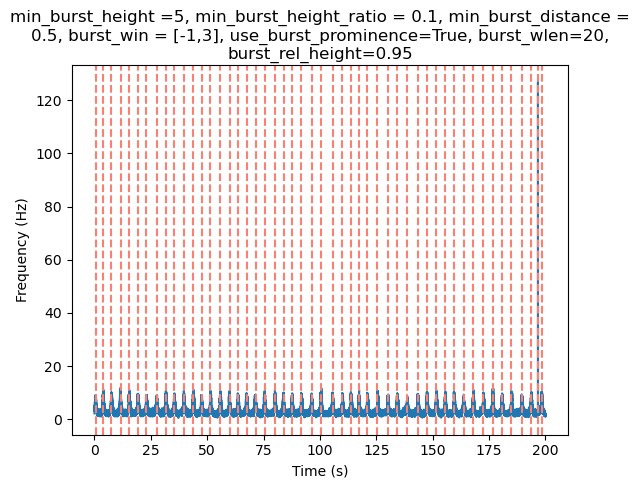

In [127]:
t=params_dict["params_analysis"]["dt_poprate"] / b2.second
dt_bin=params_dict["params_settings"]["dt"] / b2.second
pop_sampler=params_dict["params_analysis"]["pop_sampler"]
smooth_std=params_dict["params_analysis"]["smooth_std"]
dt=params_dict["params_analysis"]["dt_poprate"] / b2.second

population_spiking_vector_spikes = spikes_summary.bin_population_spikes(
    data,
                    t_start=0,
                    t_end=200,
                    dt=dt_bin,
                    return_fr=True,
                    smooth_std=smooth_std,
                    downsample_factor=int(dt/dt_bin)
                    )

burst_stats_pop_spiking = spikes_summary.get_popburst_peaks(
    population_spiking_vector_spikes[1],
    fs=b2.second / params_dict["params_analysis"]["dt_poprate"],
    min_burst_height =5,
    min_burst_height_ratio = 0.05,
    min_burst_distance = 0.5,
    burst_win = [-1,3],
    use_burst_prominence=True,
    burst_wlen=20,
    burst_rel_height=0.95,
    verbose=True,
    burst_max_window=[0, None],
)

#plotting
plt.plot(population_spiking_vector_spikes[0], population_spiking_vector_spikes[1])
plt.title('min_burst_height =5, min_burst_height_ratio = 0.1, min_burst_distance = 0.5, burst_win = [-1,3], use_burst_prominence=True, burst_wlen=20, burst_rel_height=0.95',wrap =True)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

for burst in burst_stats_pop_spiking['burst_times']:
    plt.axvline(x=burst, color='salmon', linestyle='--')

WARNING    /tmp/ipykernel_2789336/1009833665.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data), '.k', color='darkgreen', markersize=0.01)  # Each spike as a vertical line
 [py.warnings]


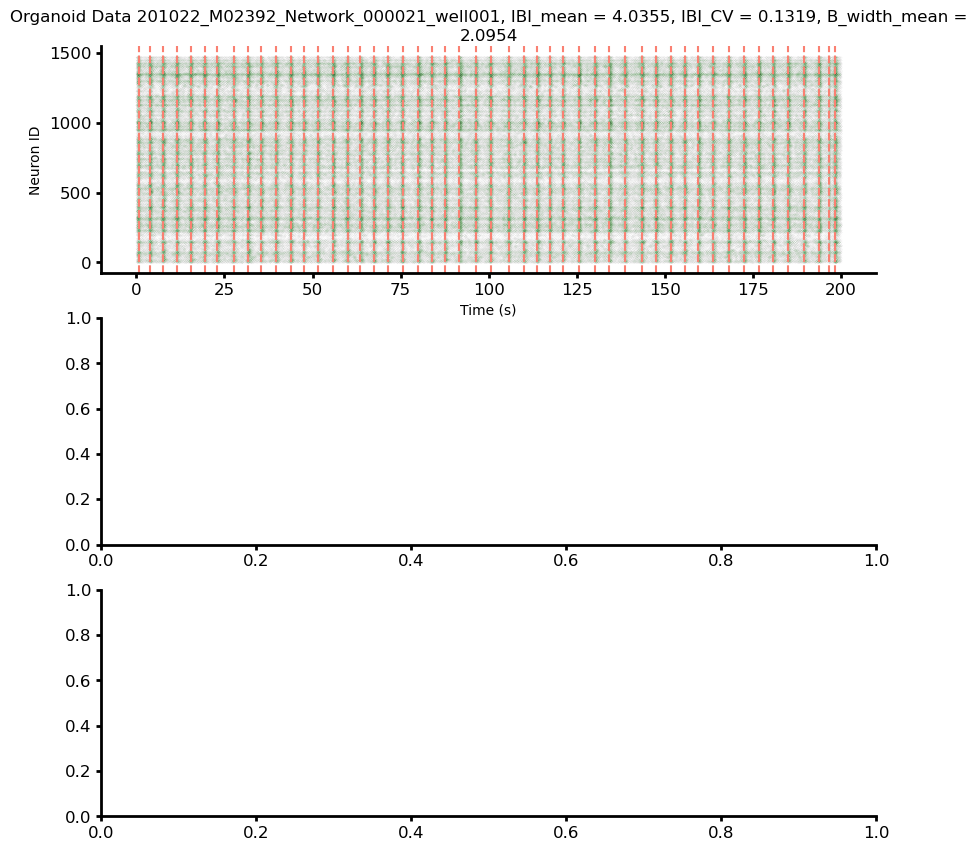

In [ ]:
#data to plot in raster with new detected bursts

params_dict['params_analysis']['min_burst_height_ratio'] = 0.05
data_analysis = analysis_utils.compute_spike_burst_features({'exc_spikes':data,'t_end': 200}, params_dict)

fig1, ax = plt.subplots(nrows=1, ncols=1, sharex=False,figsize=(10, 10))

for neuron_id_data, spike_train in data.items():
    spike_times = spike_train[spike_train <= 200]  # Filter spike times to 200 seconds
    ax.plot(spike_times, np.ones_like(spike_times) * (neuron_id_data), '.k', color='darkgreen', markersize=0.01)  # Each spike as a vertical line

# Formatting the plot
ax.set_xlabel("Time (s)")
ax.set_ylabel("Neuron ID")
for burst in data_analysis[2]['burst_times']:
    ax.axvline(x=burst, color='salmon', linestyle='--')

ax.set_title("Organoid Data {}, IBI_mean = {:.4f}, IBI_CV = {:.4f}, B_width_mean = {:.4f}".format(data_info['key'], data_analysis[0]['burst_interval_mean'].iloc[0], data_analysis[0]['burst_interval_cv'].iloc[0], data_analysis[0]['burst_width_mean'].iloc[0]), wrap=True)
# Formatting the plot
for axis in ax:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_linewidth(2)
    axis.spines['bottom'].set_linewidth(2)
    axis.tick_params(width=2, labelsize=12)

filter out early stopped from data frame consinting of Richard's presampled posterior | PSD

In [48]:
#filter out all the data that has early stopped !!!! 
df_synthetic = df_xos[df_xos['params_analysis.early_stopped'] == False] #pre True nema vypocitane ziadne hodnoty a pre False su tam zjavne aj early stopped simulacie??
# ideme to skusit filtrovat podla random seedu?
df_synthetic

params_settings.batch_seed  params_settings.random_seed  \
0                         7149324                            4   
1                         7149324                           97   
2                         7149324                          178   
3                         7149324                          283   
4                         7149324                          390   
...                           ...                          ...   
25070                     7149324                      2507220   
25071                     7149324                      2507402   
25072                     7149324                      2507431   
25073                     7149324                      2507437   
25074                     7149324                      2507461   

                  x_o        inference.type  infer.log_prob  \
0       3285553_18970              gt_resim        7.528021   
1       3285553_18970               NPE_map       17.639406   
2       3285553_18970              NPE_mean        8.938214   
3       3285553_18970  NPE_samples_prune_50       12.735332   
4       3285553_18970  NPE_samples_prune_50       12.446563   
...               ...                   ...             ...   
25070  3285553_485697  NPE_samples_prune_50       11.213965   
25071  3285553_485697  NPE_samples_prune_50       11.211856   
25072  3285553_485697  NPE_samples_prune_50       11.211505   
25073  3285553_485697  NPE_samples_prune_50       11.209842   
25074  3285553_485697  NPE_samples_prune_50       11.209804   

       params_net.exc_prop  params_net.p_e2e  params_net.p_e2i  \
0                 0.955352          0.098917          0.051536   
1                 0.918083          0.062381          0.084252   
2                 0.858290          0.049717          0.065721   
3                 0.896675          0.056465          0.073468   
4                 0.905299          0.065546          0.097235   
...                    ...               ...               ...   
25070             0.733269          0.053099          0.060286   
25071             0.777234          0.018545          0.038095   
25072             0.813084          0.025096          0.051356   
25073             0.853898          0.034504          0.049074   
25074             0.936653          0.027972          0.043578   

       params_net.p_i2e  params_net.p_i2i  ...  psd_495.5  psd_496.0  \
0              0.112586          0.195101  ...   0.001625   0.001670   
1              0.129208          0.195929  ...   0.006500   0.006214   
2              0.128339          0.110392  ...   0.004487   0.003923   
3              0.111371          0.192815  ...   0.011030   0.009166   
4              0.118228          0.081547  ...   0.004183   0.004213   
...                 ...               ...  ...        ...        ...   
25070          0.181629          0.172075  ...   0.457975   0.459075   
25071          0.070415          0.068629  ...   0.018659   0.022143   
25072          0.056228          0.152682  ...   0.094679   0.086466   
25073          0.097151          0.196987  ...   0.012255   0.012476   
25074          0.155313          0.168869  ...   0.041869   0.042981   

       psd_496.5  psd_497.0  psd_497.5  psd_498.0  psd_498.5  psd_499.0  \
0       0.001661   0.001782   0.002010   0.001769   0.001663   0.001607   
1       0.007043   0.007804   0.007156   0.006799   0.006705   0.006492   
2       0.003831   0.003864   0.003926   0.003414   0.003211   0.003799   
3       0.009431   0.009598   0.009220   0.009876   0.010273   0.010007   
4       0.004374   0.004372   0.004998   0.004830   0.004693   0.004918   
...          ...        ...        ...        ...        ...        ...   
25070   0.480200   0.415930   0.407151   0.401931   0.398588   0.405017   
25071   0.022212   0.017456   0.023092   0.022948   0.020091   0.031970   
25072   0.085048   0.111254   0.119507   0.118749   0.172083   0.259870   
25073   0.009745   0.012861   0.015441   0.021813

# Calculate Eucledean distance between the target summary data and all the (good) Richard's data set
 - but I have to have some selection steps to avoid taking 
    - Nan values in the particular summary stats
    - early stopped simulations 

what kind of features should I prioritize for? 
Richard chose to train on (IBI mean, CV, and burst width) and PSD (500 points). 

Also "I ran into some issues using the spike / ISI stats, basically the issue being that the simulated networks didn't produce similar stats as my recordings at the single-neuron level, which is why I resorted to only reproducing the population-level burst metrics."


Code for figuring out the closest simulation to organoid data

In [ ]:
#columns_to_extract = ['burst_num','burst_interval_mean','burst_interval_cv','burst_width_mean']

def calculate_differences(values, target_value):
    # Calculate Euclidean distances from each row to the target set
    differences = np.sqrt(((values - target_value) ** 2))
    return differences

def find_closest_sim_whole_euclidean_distance(df_synthetic, data_analysis, columns_to_extract,n_oversample):
    closest_index_for_every_column = {}
    for col in columns_to_extract[2:]:
        values = df_synthetic[col] 
        target_value = data_analysis[0][col].iloc[0] #df_organoids[col].iloc[0]
        differences = calculate_differences(values, target_value)
        lowest_indices = differences.dropna().nsmallest(n_oversample).index
        #closest_sets = df_synthetic.iloc[lowest_indices] #this just to check the values
        closest_index_for_every_column[col] = lowest_indices

    return closest_index_for_every_column

closest_index_for_every_column = find_closest_sim_whole_euclidean_distance(df_synthetic,data_analysis, columns_to_extract,n_oversample=5000)


In [114]:
from collections import Counter
 #Flatten the list of indices across all metrics
all_indices = [index for indices in closest_index_for_every_column.values() for index in indices]

# Count the occurrences of each index
index_counts = Counter(all_indices)

# Find the 5 most common indices and their frequencies
most_common_indices = index_counts.most_common(10)

print("The 10 most common indices and their frequencies are:")
for index, frequency in most_common_indices:
    print(f"Index: {index}, Frequency: {frequency}")

The 10 most common indices and their frequencies are:
Index: 4306, Frequency: 25
Index: 10797, Frequency: 25
Index: 4257, Frequency: 24
Index: 3844, Frequency: 24
Index: 3807, Frequency: 24
Index: 4935, Frequency: 24
Index: 3814, Frequency: 24
Index: 4246, Frequency: 24
Index: 10926, Frequency: 23
Index: 4842, Frequency: 23


In [ ]:
for index,frequency in most_common_indices:
    print(df_synthetic.loc[index, columns_to_extract])

burst_num              49.000000
burst_interval_mean     4.104500
burst_interval_cv       0.035567
burst_width_mean        2.567276
Name: 1084, dtype: float64
burst_num              52.000000
burst_interval_mean     3.873686
burst_interval_cv       0.034173
burst_width_mean        1.396326
Name: 4377, dtype: float64
burst_num              52.000000
burst_interval_mean     3.844745
burst_interval_cv       0.170190
burst_width_mean        1.953128
Name: 21618, dtype: float64
burst_num              48.00000
burst_interval_mean     4.19717
burst_interval_cv       0.02999
burst_width_mean        1.07454
Name: 21984, dtype: float64
burst_num              53.000000
burst_interval_mean     3.806058
burst_interval_cv       0.209670
burst_width_mean        0.970325
Name: 1050, dtype: float64
burst_num              53.000000
burst_interval_mean     3.770596
burst_interval_cv       0.025546
burst_width_mean        1.451966
Name: 1163, dtype: float64
burst_num              53.000000
burst_interval_

In [115]:
data_analysis[0].loc[:,['burst_num', 'burst_interval_mean', 'burst_interval_cv', 'burst_width_mean']]

burst_num  burst_interval_mean  burst_interval_cv  burst_width_mean
0         50             4.035531           0.131875          2.095417

# Trying to condidion on more features
burst_interval_mean
burst_interval_cv
burst_width_mean

In [ ]:
#single feature
#ordered = np.abs(df_selected['burst_num'] - data_analysis[0]['burst_num'].iloc[0]).dropna().nsmallest(10).index

ordered = [t[0] for t in most_common_indices]
ordered

[4306, 10797, 4257, 3844, 3807, 4935, 3814, 4246, 10926, 4842]

In [117]:
#now I want to visualize the found similar features ones in a raster plot
#however, I always have to simulate the data first

# Some housekeeping to set random seed identifiers and set up simulation configurations
n_samples = 10
params_dict_run_my_try = data_utils.fill_params_dict(params_dict, df_synthetic.loc[ordered], posterior.as_dict, n_samples) 

#here i have to change the sim time to seconds for some readom 
for n in range(n_samples):
    params_dict_run_my_try[n]['params_settings']['sim_time'] = 200*b2.second


params_settings.batch_seed has no prior. Copied as bare value without unit.
params_settings.random_seed has no prior. Copied as bare value without unit.
params_settings.sim_time has no prior. Copied as bare value without unit.
params_settings.real_run_time has no prior. Copied as bare value without unit.
params_analysis.early_stopped has no prior. Copied as bare value without unit.


In [118]:
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)

sim_parallel = True
if sim_parallel:
    from multiprocessing import Pool

    start_time = time()
    with Pool(n_samples) as pool:
        sim_collector = pool.map(runners.adex_simulator, params_dict_run_my_try)
    print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()
        sim_collector.append(runners.adex_simulator(params_dict_run_my_try[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)

cache non-existent.
7149324-435890|7149324-10916057149324-4304507149324-3826527149324-3867927149324-505476|||||7149324-3833427149324-4966317149324-429657||7149324-1105678||Simulations took 405.50 seconds.
cache cleared: ./.cache/.


### Data preprocessing
The target observation PSD has to undergo a few preprocessing steps, such as taking the log, normalizing, and re-scaling, etc. These transformations are tracked in the posterior network object (`posterior.x_bounds_and_transforms` and `posterior.x_standardizing_func`), and just need to be applied to the dataset. 

If you want to run this demo on a new dataset, you just need to replace `df_xos` with your own dataframe, where each row must contain, among other features, a PSD from 0.5 to 495Hz, at 0.5Hz frequency resolution. Alternatively, it can be supplied as a log10-PSD in a numpy array (`xo`), where only the last step is necessary (standardizing and converting to torch tensor).

In [107]:
df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe_psd(
    df_xos.loc[[idx_xo]],
    posterior.x_bounds_and_transforms,
    drop_nans=False,
    replace_infs=True,
)
xo = df_xos_preproc.loc[idx_xo][cols_features].values
xo_tensor = posterior.x_standardizing_func(Tensor(xo[None, :]))
print(f"Target observation has shape {xo_tensor.shape}")

0 sims dropped due to early stopping.
0 sims dropped due to manual criteria.
0 sims dropped due to power threshold discard.
0 samples discarded in total.
Target observation has shape torch.Size([1, 990])


### Plot the discovered model simulations
Finally, we plot a 30 second segment of the simulated spike trains, as well as the population firing rate and power spectrum, of each discovered model.

In [119]:
results_collector = [
    analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector
]

In [122]:
params_dict['params_analysis']

{'t_early_stop': 10.1 * second,
 'early_stop_window': array([ 0.1, 10.1]),
 'early_stopped': False,
 'stop_fr_norm': (0.0001, 0.99),
 'do_spikes': True,
 'pop_sampler': {'exc': None},
 'analysis_window': [5.1, None],
 'smooth_std': 0.005,
 'dt_poprate': 1. * msecond,
 'min_num_spikes': 3,
 'do_bursts': True,
 'use_burst_prominence': True,
 'min_burst_height': 10,
 'min_burst_height_ratio': 0.05,
 'min_burst_distance': 0.5,
 'burst_win': [-1, 3],
 'burst_wlen': 20,
 'burst_rel_height': 0.95,
 'do_psd': True,
 'nperseg_ratio': 2,
 'noverlap_ratio': 0.75,
 'f_lim': 400,
 'do_pca': True,
 'n_pcs': 100,
 'pca_bin_width': 10. * msecond,
 'pca_smooth_std': 50. * msecond,
 'summary_set_name': 'MK1',
 'do_plot': True,
 'min_subpeak_prom_ratio': 0.25,
 'min_subpeak_distance': 0.1,
 'burst_max_window': [20.0, None]}

In [123]:
#run the data analysis on these 10 simulations and find if they really have 3 bursts
bursts_after = {}
params_dict['params_analysis']['min_burst_height_ratio'] = 0.8
for i_sim, results in enumerate(results_collector):
    data_analysis_after = analysis_utils.compute_spike_burst_features({'exc_spikes':sim_collector[i_sim][1]['exc_spikes'],'t_end':200.1}, params_dict) #does having the wrong params_dict matter?
    #print(data_analysis_after[0].keys())  # Print the keys to understand the structure
    if 'burst_num' in data_analysis_after[0]:
        print(i_sim,' ',data_analysis_after[0]['burst_num'].values)
    else:
        print(i_sim,' ',"Key 'burst_num' not found in the analysis results.")
    
    bursts_after[i_sim] = data_analysis_after[2]['burst_times']


0   [12]
1   [5]
2   [8]
3   [50]
4   [20]
5   [11]
6   [3]
7   [5]
8   [14]
9   [50]


WARNING    /tmp/ipykernel_2789336/3871962112.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax[2].plot(spike_train, np.ones_like(spike_train) * (2000 - neuron_id), '.k', color='C1', markersize=0.1)
 [py.warnings]
WARNING    /tmp/ipykernel_2789336/3871962112.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax[2].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color='C0', markersize=0.1)
 [py.warnings]
WARNING    /tmp/ipykernel_2789336/3871962112.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data),'.k',color='darkgreen',markersize=0.01)  # Each spike as a verti

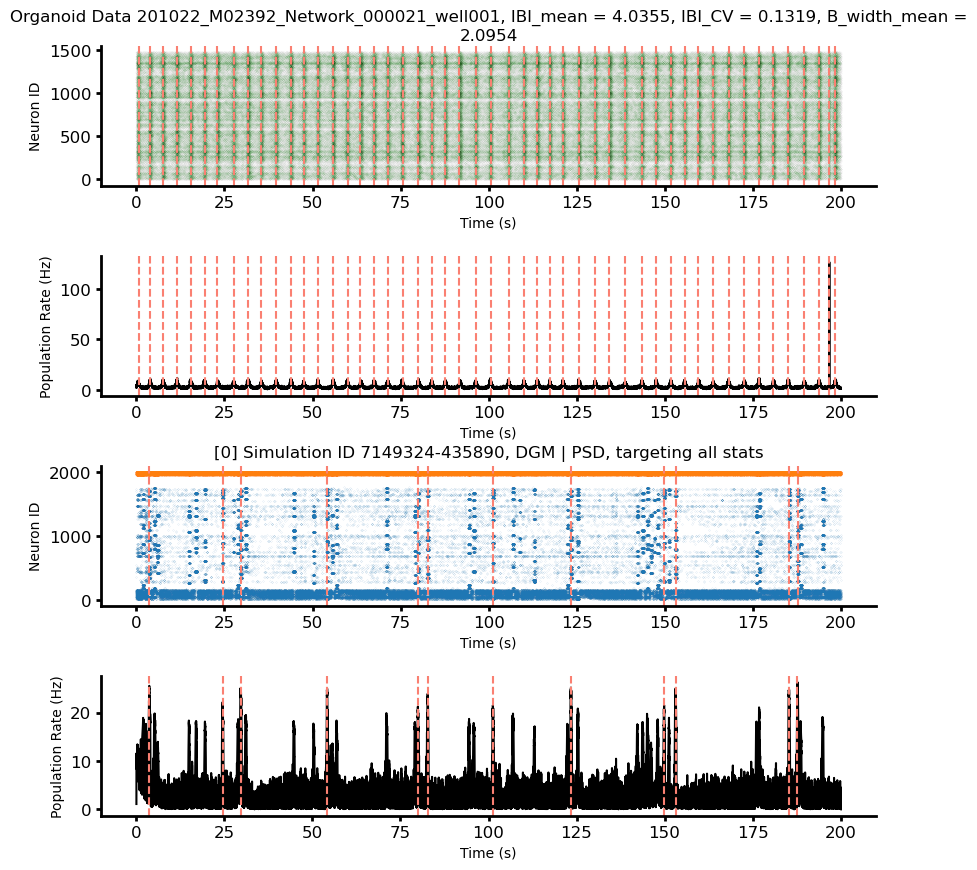

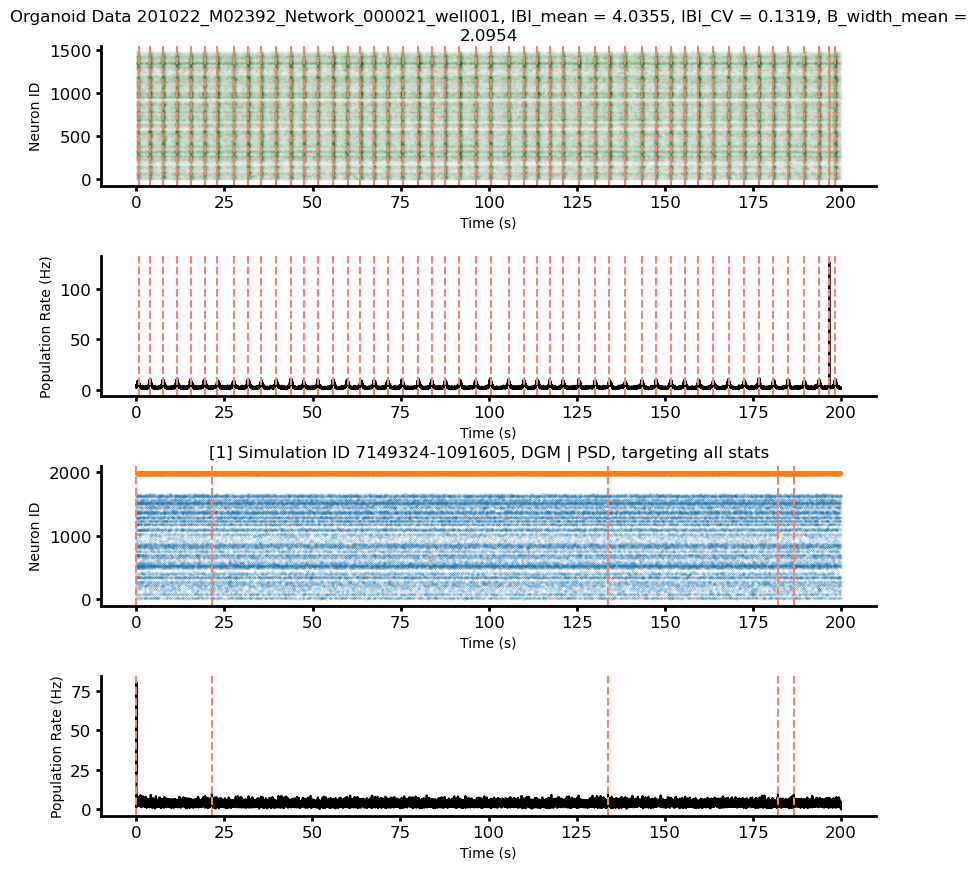

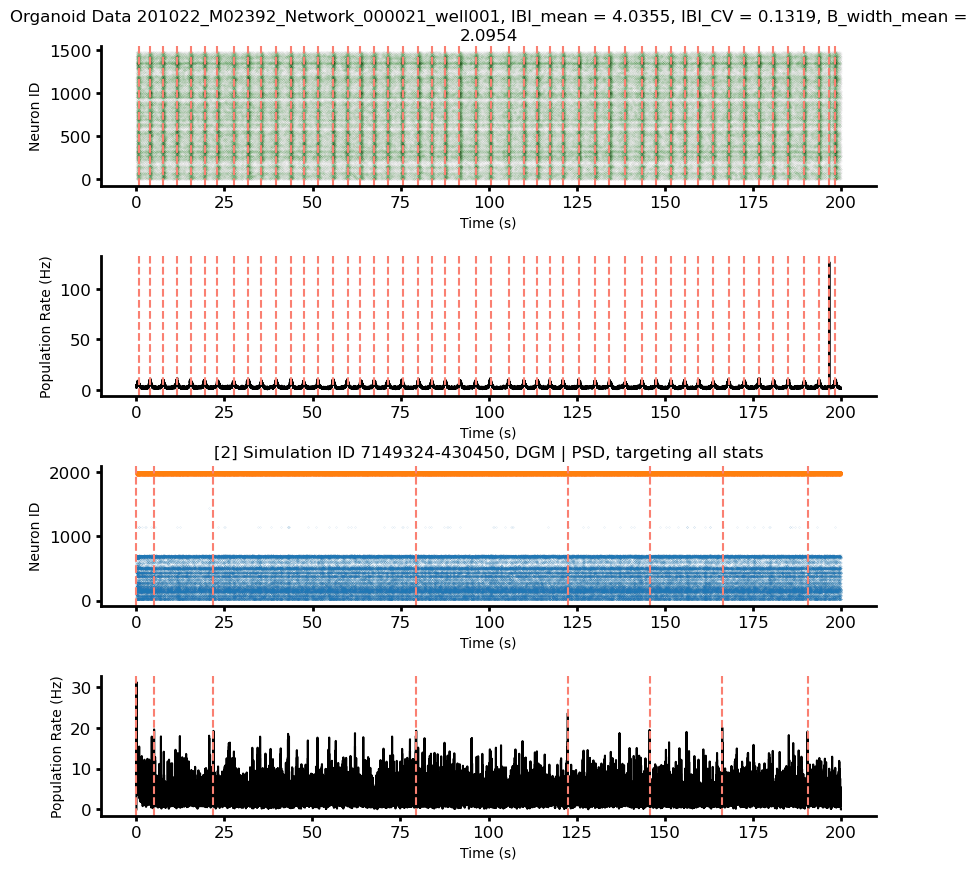

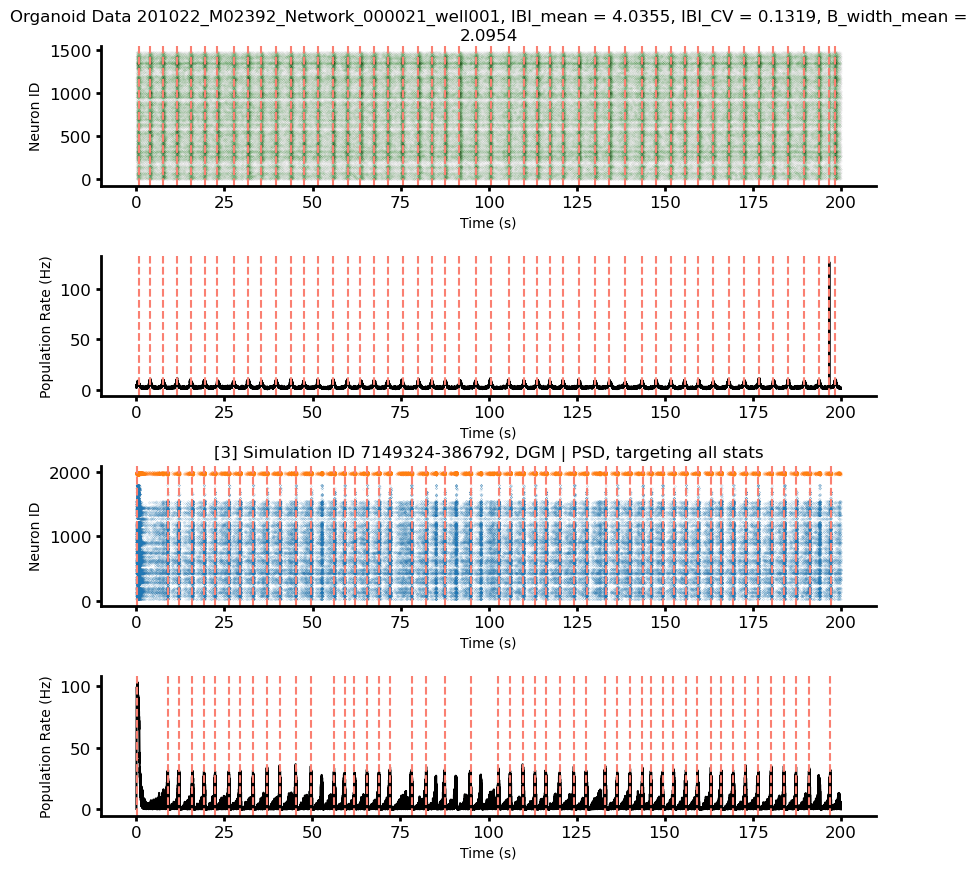

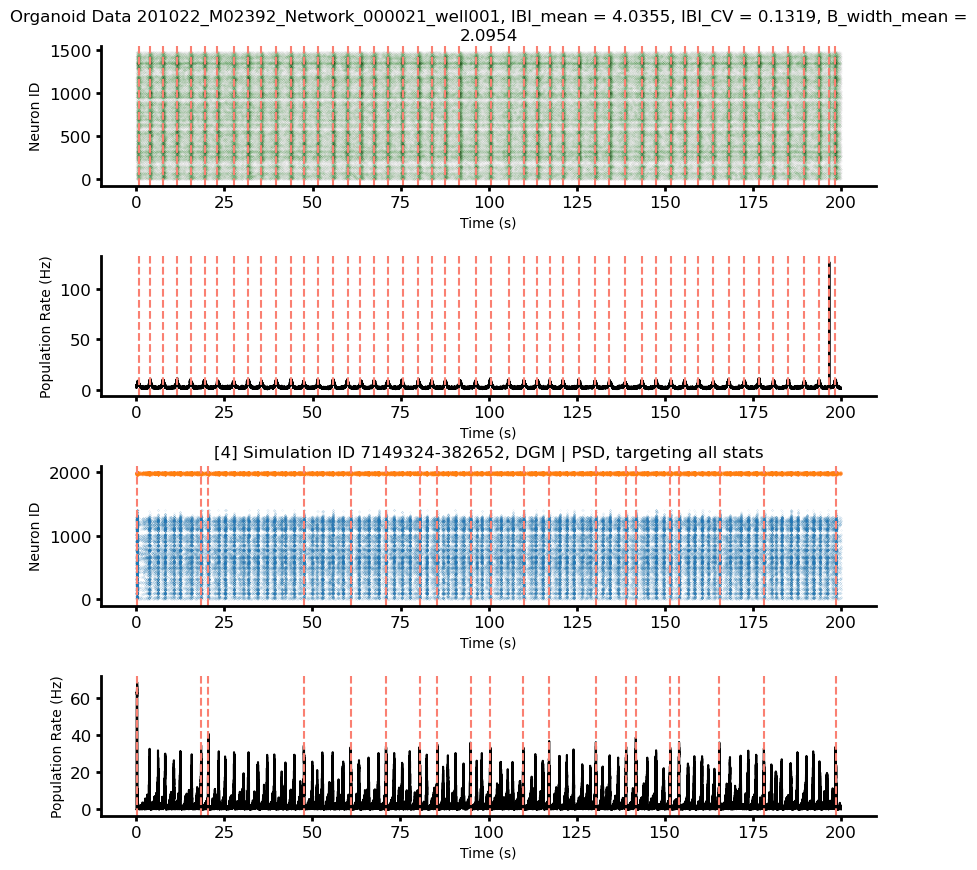

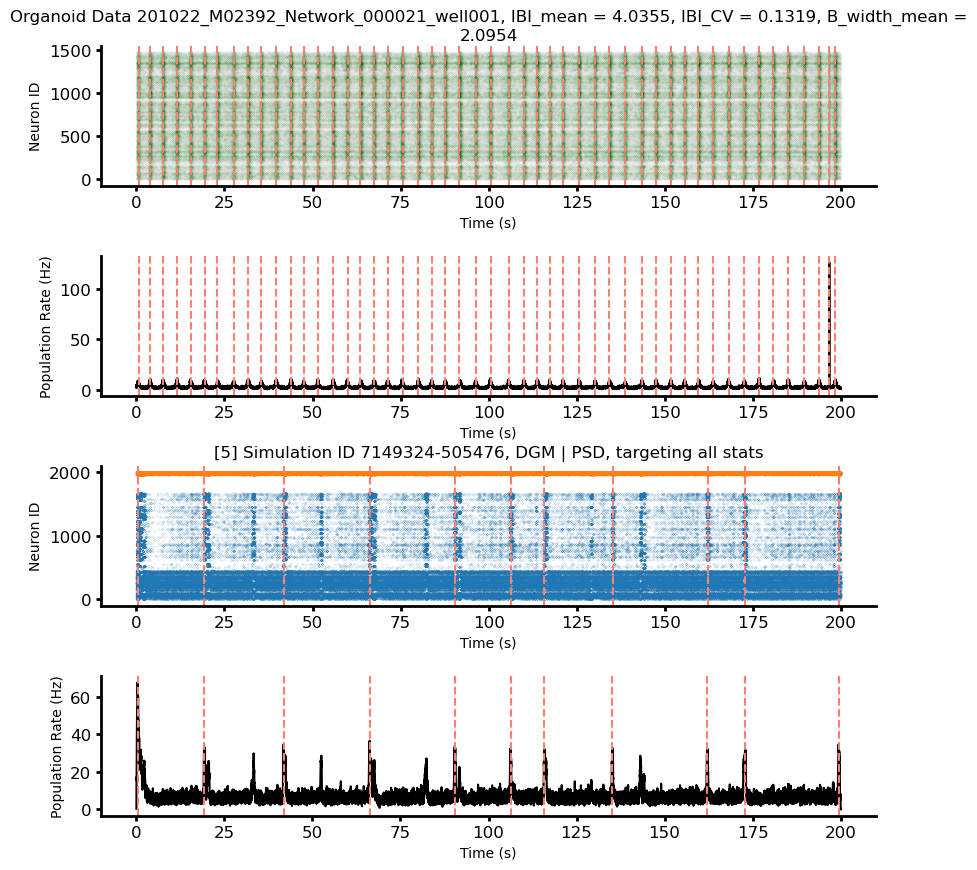

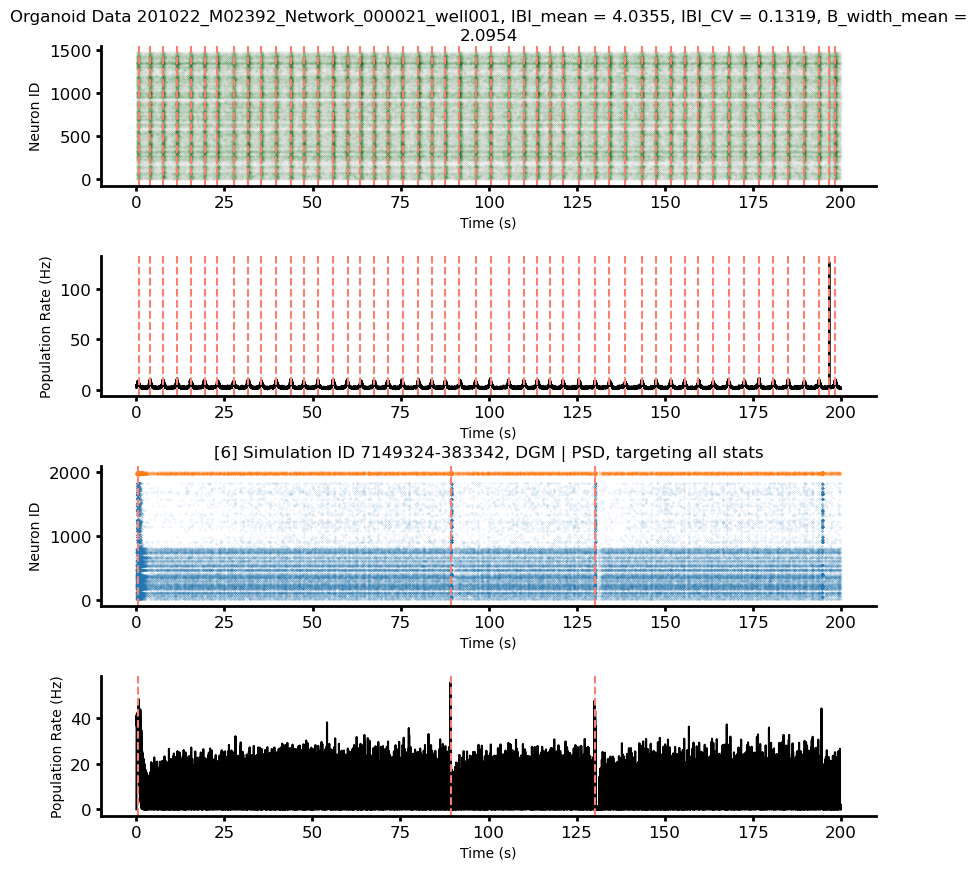

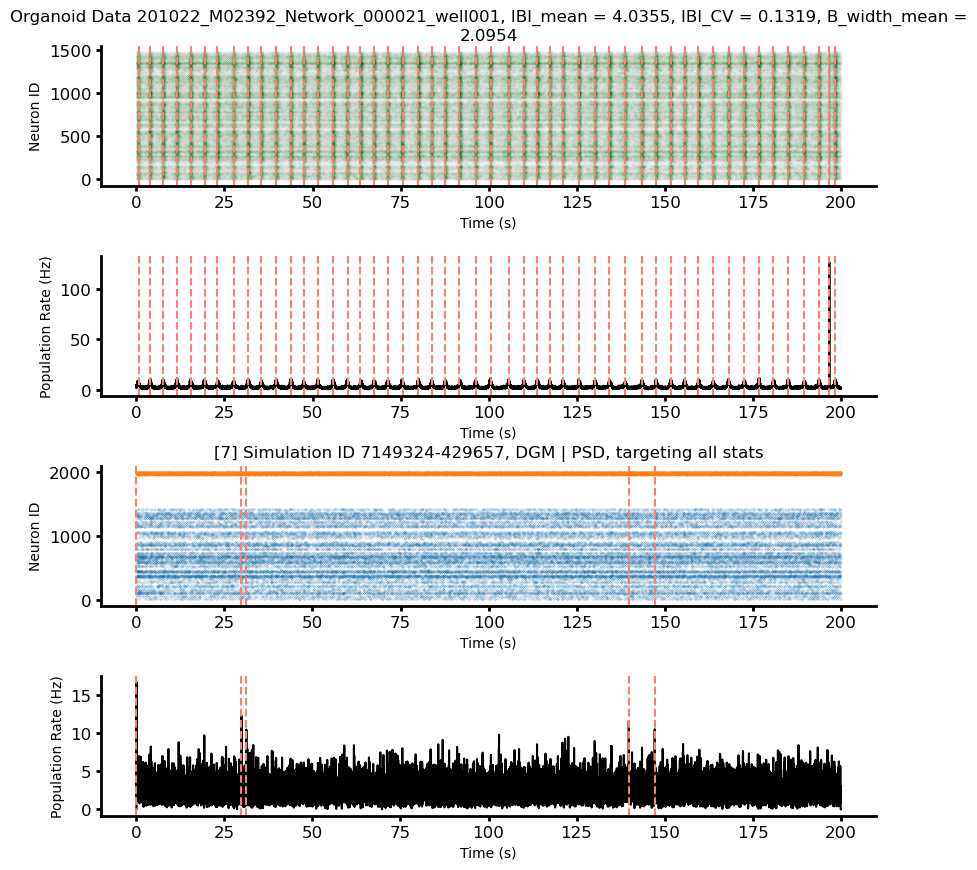

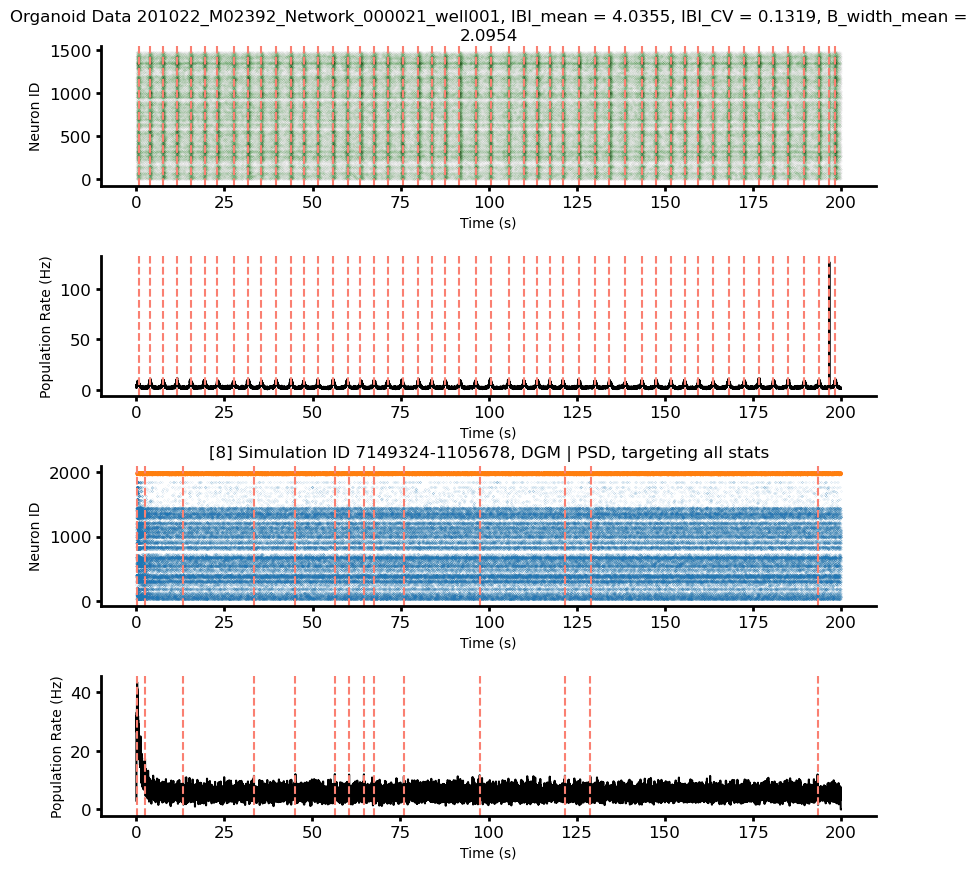

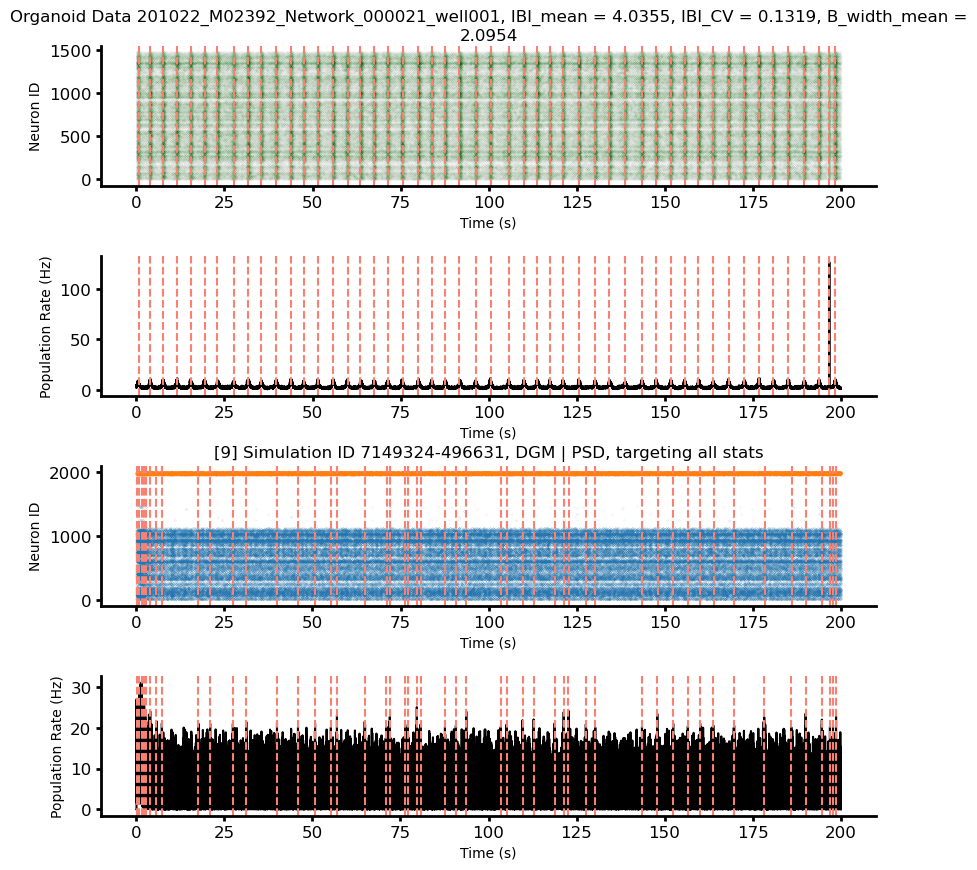

In [128]:
# Plot the results

for i_sim, results in enumerate(results_collector):
    fig1, ax = plt.subplots(nrows=4, ncols=1, sharex=False,figsize=(10, 10))

    #rasters
    n_exc = int(df_synthetic['params_net.exc_prop'].iloc[0] * 2000)
    for neuron_id, spike_train in sim_collector[i_sim][1]['inh_spikes'].items():
        ax[2].plot(spike_train, np.ones_like(spike_train) * (2000 - neuron_id), '.k', color='C1', markersize=0.1)
    for neuron_id, spike_train in sim_collector[i_sim][1]['exc_spikes'].items():
        ax[2].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color='C0', markersize=0.1)
    
    ax[2].set_ylabel("Neuron ID")
    title = "[{}] Simulation ID {}-{}, DGM | PSD, targeting all stats".format(i_sim, sim_collector[i_sim][0]['params_settings']['batch_seed'],sim_collector[i_sim][0]['params_settings']['random_seed'])
    ax[2].set_title(title,wrap = True)
    ax[2].set_xlabel("Time (s)")

    #pop average rates
    ax[3].plot(results_collector[i_sim]["pop_rates"]["t_ds"], results_collector[i_sim]["pop_rates"]["avgpop_rate"], "k")
    ax[3].set_ylabel("Population Rate (Hz)")
    ax[3].set_xlabel("Time (s)")

    for burst in bursts_after[i_sim]:
        ax[2].axvline(x=burst, color='salmon', linestyle='--')
        ax[3].axvline(x=burst, color='salmon', linestyle='--')
    

    #data
    for neuron_id_data,spike_train in data.items(): 
        spike_times = spike_train[spike_train <= 200]  # Filter spike times to 200 seconds
        ax[0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data),'.k',color='darkgreen',markersize=0.01)  # Each spike as a vertical line

        # Formatting the plot
        ax[0].set_xlabel("Time (s)")
        ax[0].set_ylabel("Neuron ID")
    for burst in data_analysis[2]['burst_times']:
        ax[0].axvline(x=burst, color='salmon', linestyle='--')

    ax[0].set_title("Organoid Data {}, IBI_mean = {:.4f}, IBI_CV = {:.4f}, B_width_mean = {:.4f}".format(data_info['key'],data_analysis[0]['burst_interval_mean'].iloc[0],data_analysis[0]['burst_interval_cv'].iloc[0],data_analysis[0]['burst_width_mean'].iloc[0]),wrap=True)
    
    #plotting average popr rate
    ax[1].plot(population_spiking_vector_spikes[0], population_spiking_vector_spikes[1],c='black')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Population Rate (Hz)')

    for burst in burst_stats_pop_spiking['burst_times']:
        ax[1].axvline(x=burst, color='salmon', linestyle='--')

    # Formatting the plot
    for axis in ax:
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['left'].set_linewidth(2)
        axis.spines['bottom'].set_linewidth(2)
        axis.tick_params(width=2,labelsize=12)
    # Adjust the space between subplots
    plt.subplots_adjust(hspace=0.5)
    #fig1.savefig('figures/targeting_isi_simple/'+title+'.png', dpi=300)

